In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf 
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from google.colab import drive
import os

# Mount drive
drive.mount('/content/gdrive')
PROJECT_PATH = '/content/gdrive/My Drive/DL_05/'

# List loaded files 
print(os.listdir(PROJECT_PATH))

import pandas as pd

# Load train and test dataset 
train_ds = pd.read_csv(PROJECT_PATH + 'sst_train.txt', delimiter= "\t", header=None, usecols=[0,1], names=['label', 'sentence'])
dev_ds = pd.read_csv(PROJECT_PATH + 'sst_dev.txt', delimiter= "\t", header=None, usecols=[0,1], names=['label', 'sentence'])
test_ds = pd.read_csv(PROJECT_PATH + 'sst_test.txt', delimiter= "\t", header=None, usecols=[0,1], names=['label', 'sentence'])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['sst_test.txt', 'sst_dev.txt', 'sst_train.txt', 'training_checkpoints']


## Text classification model

### Task 1. Load and preprocess the data:
• You will use the char-level representation of text in your RNN mod-
els. Specifically, use the extended ASCII with 256 characters, and
represent each character in a sentence as a one-hot-encoding.

> Here I used slightly smaller size (size of unique characters count in all datasets

In [0]:
from keras.preprocessing.text import Tokenizer

# Join train and test for data analysis and creating the tokenizer
whole_corpus = train_ds["sentence"] 
whole_corpus.append(test_ds["sentence"])
whole_corpus.append(dev_ds["sentence"])

# Convert data to ascii
whole_corpus = whole_corpus.apply(lambda x: str(x.encode("ascii", "ignore")))

# Fit tokenizer to data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(whole_corpus)

print(tokenizer.word_index)


Using TensorFlow backend.


{' ': 1, 'e': 2, 't': 3, 'a': 4, 'i': 5, 'o': 6, 's': 7, 'n': 8, 'r': 9, 'l': 10, 'h': 11, 'd': 12, 'c': 13, 'u': 14, 'm': 15, 'b': 16, 'f': 17, 'g': 18, "'": 19, 'y': 20, 'p': 21, 'w': 22, '.': 23, 'v': 24, ',': 25, '"': 26, 'k': 27, '-': 28, 'x': 29, 'j': 30, '`': 31, 'q': 32, 'z': 33, '(': 34, ')': 35, '0': 36, '1': 37, '?': 38, ':': 39, '9': 40, '2': 41, ';': 42, '!': 43, '/': 44, '5': 45, '8': 46, '3': 47, '7': 48, '4': 49, '6': 50, '*': 51, '&': 52, '$': 53, '#': 54, '+': 55, '=': 56}


In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers
import numpy as np


def get_encoded_data(dataset, max_sentence_length, unique_char_cnt):
    
    sentences = dataset["sentence"].apply(lambda x: str(x.encode("ascii", "ignore")))
    encoded_sentences = []
    
    # Convert each sentence to it's character number representation
    for sentence in sentences:
        sentence = sentence.replace("%", "")
        sentence = np.array(tokenizer.texts_to_sequences(sentence), dtype=np.uint8)
        sentence = sentence.flatten()
        encoded_sentences.append(sentence)
    
    # In tokenizer 0 is never used - can be used for padding
    # +1 is then added to for the padding character to unique_char_cnt
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=max_sentence_length, padding='post', truncating='post')
    encoded_sentences = to_categorical(encoded_sentences, num_classes=unique_char_cnt+1)

    print(f"Data slice has shape of {encoded_sentences[0].shape}")

    mask_value=to_categorical(0, num_classes=unique_char_cnt+1)
    embedding = layers.Masking(mask_value=mask_value)
    masked_output = embedding(encoded_sentences)

    return encoded_sentences, pd.get_dummies(dataset["label"]).to_numpy()


In [0]:

# Get info for data encoding
# Max sentece lenght trimmed to some meaningful max length 
max_sentece_len = 200  # whole_corpus.map(len).max()
unique_char_cnt = len(tokenizer.word_index)

# Get data encoded to one hot encoding
x_train_oh, y_train_oh = get_encoded_data(train_ds, max_sentece_len, unique_char_cnt)
x_val_oh, y_val_oh = get_encoded_data(dev_ds, max_sentece_len, unique_char_cnt)
x_test_oh, y_test_oh = get_encoded_data(test_ds, max_sentece_len, unique_char_cnt)




Data slice has shape of (200, 57)
Data slice has shape of (200, 57)
Data slice has shape of (200, 57)


In [0]:
# Label meaning dictanionary
sentiment_dict =  { 0: "strongly negative", 
                   1: "weakly negative", 
                   2: "neutral",
                   3: "weakly positive",
                   4: "strongly positive"
}

#### Presicion, reccal, F1 measure, in the final solution used scipy evaluation 

In [0]:
import keras.backend as K


# Modified answer by Shamit Verma on https://datascience.stackexchange.com/questions/48246/how-to-compute-f1-in-tensorflow question
def presicion(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return  true_positives / (possible_positives + K.epsilon())

# F1 = 2TP / (2TP + FP + FN)
def f_measure(y_true, y_pred):
    precision_val = presicion(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_val = 2*(precision_val*recall_val)/(precision_val+recall_val+K.epsilon())
    return (f1_val)

#### Define and get compiled model 

In [0]:
from tensorflow.keras import layers, Model, optimizers


def get_build_classification_model(rnn_layer_type=layers.RNN, lr=0.01, hidden_size=256, dataset_example=None, dropout=0.2, bidirectional=False, special_metrics=False):
    # Define input shapes and masking value by dataset example 
    input_shape=dataset_example[0].shape
    mask_value=to_categorical(0, num_classes=input_shape[1])

    # Define layers
    input_layer = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=mask_value)(input_layer)
    
    if bidirectional:
        x = layers.Bidirectional(rnn_layer_type(hidden_size,return_sequences=True))(x)
    else:
        x = rnn_layer_type(hidden_size,return_sequences=True)(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(dropout)(x)
    logits = layers.Dense(5, activation='softmax')(x)

    # Instantiate the model given inputs and outputs.
    model = Model(inputs=input_layer, outputs=logits)

    # Set names for printing and saving options
    model.rnn_name = str(rnn_layer_type).split(".")[-1].strip("'>")
    model.show_name = f"{model.rnn_name}-({hidden_size}_{dropout}_{lr}_{bidirectional})"
    model.print_name = f"{model.rnn_name}({hidden_size} Dropout:{dropout} LR:{lr} Bidirect:{bidirectional})" 

    return model
def get_compiled_classification_model(rnn_layer_type=layers.RNN, lr=0.01, hidden_size=256, dataset_example=None, dropout=0.2, bidirectional=False, special_metrics=False):

    model = get_build_classification_model(rnn_layer_type=rnn_layer_type, lr=lr, hidden_size=hidden_size, dataset_example=dataset_example, dropout=dropout, bidirectional=bidirectional, special_metrics=special_metrics)
    
    # Set metrics and return compiled model
    if special_metrics:
        metrics = ['accuracy', f_measure, recall, presicion]
    else:
        metrics = ['accuracy']

    optimizer = optimizers.Adam(lr=lr)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=metrics)




    return model


In [0]:
import matplotlib.pyplot as plt

# Plotting validation and train accuracy
def plot_graphs(ax, history, string, title):
    ax.set_title(title)
    ax.plot(history.history[string])
    ax.plot(history.history['val_'+string], '')
    ax.set_xlabel("Epochs",fontsize=12)
    ax.set_ylabel(string, fontsize=12)
    ax.legend([string, 'val_'+string])


#### Callbacks and checkpoints, learning rate decay  functions 




In [0]:

# Directory where the checkpoints will be saved
checkpoint_dir = PROJECT_PATH + '/training_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

import datetime
from tensorflow.keras import callbacks
import math 
from IPython.display import Markdown

def printmd(string):
    display(Markdown(string))

# Load the TensorBoard notebook extension
# !rm -rf "./logs/LSTM"
# %load_ext tensorboard
# %tensorboard --logdir logs


logdir = "logs" # Directory, where info for tesorboard is stored 
checkpoint_dir = PROJECT_PATH + '/training_checkpoints' # Directory where the checkpoints will be saved

def crate_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def get_tensorboard_callback(model_rnn_name, model_show_name):
    
    model_logdir = logdir + f"/{model_rnn_name}"
    now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_prefix = os.path.join(model_logdir,  f"{now}--{model_show_name}" )

    crate_dir(model_logdir) 
    return callbacks.TensorBoard(log_prefix, histogram_freq=1)
    

def get_checkpoint_callback(model_rnn_name):
    # Name of the checkpoint files
    checkpoint_model_dir =  checkpoint_dir + f"/{model_rnn_name}"
    checkpoint_prefix = os.path.join(checkpoint_model_dir, "ckpt_{epoch}")
    
    crate_dir(checkpoint_model_dir)
    return callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
    


def get_model_callbacks(model_rnn_name, model_show_name):
    tensorboard_callback = get_tensorboard_callback(model_rnn_name, model_show_name)
    checkpoint_callback = get_checkpoint_callback(model_rnn_name)

    return tensorboard_callback, checkpoint_callback



def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))


# loss_history = LossHistory()
# lrate = callbacks.LearningRateScheduler(step_decay)

# loss_history, lrate,

### Task 2. Implement RNN, LSTM, and GRU models:
• Create the Model/Network: Define models for vanilla RNN,
LSTM and GRU networks, respectively, using the char-level representation.

> I created one function where I tested various hyperparameters possibilities, how to improve the model accuracy, then I choose the variation of parameters, which looked promising for final hyperparameters search 

#### Categorical model evaluation

In [0]:
def evaluate_categorical_models(rnn_layer_type=layers.LSTM, bidirectional=False):

    hidden_sizes = [256] #[256,  350] # 300,
    dropouts = [0.2] # , 0.3
    lrs = [0.001, 0.0001] #0.01,  

    batch_size=64
    epochs_cnt = 17 #int(x_test_oh.shape[0]/batch_size)
    steps = 17

    nrows = len(hidden_sizes) *len(dropouts)
    ncols = len(lrs)    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=False, figsize=(9, 5))
    axs_flat = axs.flat 
    
    
    model_results_df = pd.DataFrame(columns=['Model', 'Test accuracy'])
    test_accuracy = {}
    indx = 0 
    
    # tested also lr 0.00001, which showed as useless

    for hidden_size in hidden_sizes:
        for dropout in dropouts:
            for lr in lrs:  
                model = get_compiled_classification_model(rnn_layer_type=rnn_layer_type, 
                                            lr=lr,
                                            hidden_size=hidden_size,
                                            dataset_example=x_train_oh,
                                            dropout=dropout,
                                            bidirectional=bidirectional)
                
                tensorboard_callback, checkpoint_callback = get_model_callbacks(model.rnn_name, model.show_name)

                hist = model.fit( x=x_train_oh,
                                y=y_train_oh,
                                validation_data=(x_val_oh, y_val_oh),
                                batch_size=batch_size,
                                epochs=epochs_cnt,
                                # callbacks=[tensorboard_callback, checkpoint_callback],
                                callbacks=[checkpoint_callback],
                                verbose=False)

                loss, acc = model.evaluate(x_test_oh,
                                        y_test_oh,
                                        steps=steps, 
                                        verbose=False)

                plot_graphs(axs_flat[indx], hist, "accuracy", model.print_name)  
                print(f"Model with hidden size {hidden_size}, lr {lr} and dropout {dropout} has test accuracy of {acc}")
                model_results_df.loc[indx] = [model.print_name, acc]

                indx +=1 

    display(model_results_df.head())

    return model_results_df




• Train the Model: Train your model using the sentiment train sub-
set. To get the sentence encoding, use the element-wise max of all
hidden states.

### Task 3. Experimentation and Analysis Complete the following analysis, and include your findings in the report.

* Periodically compute the loss on the validation set, and create a plot
with the training and validation loss as training progresses. Is your
model overfitting? Include the plot in your report. Optional: Try
dropout if your model is overfitting.

> During the process of finding the parameters I tried various parameters and epoch length, after which the model did overfit, but this configuration gives quite reasonable train/validation difference. 

> Graphs are computed for each configuration 

* Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. A common practice is
to drop the learning rate when the loss has plateaued. Observe the
loss plots, and investigate the need for lowering the learning rate. If
needed, lower the learning rate and show the effect on the loss.
> Testing learning rates reduced to fewer options, after some runs. For overfitting I also tried to use learning rate drop, which did not seem to work better, so I did not use it in a final solution

* Experiment with the size of the hidden layer or the model architecture. How does doubling the size of the hidden layer affect the validation accuracy?
> Here I tested with various sizes, but the doubling the size did not seem to work well - the model was overfitting too much. So for the final runs I did not include that big size. 

* For each RNN model architecture, identify the best model based on
the accuracy on the dev subset.
> I did it by saving the best model weight and loading them afterwards

* For one type of RNN architecture, experiment with a bidirectional
network and compare the results with the resulting from the corresponding unidirectional network.
> For this I choose the best GRU(256 Dropout:0.2 LR:0.001 Bidirect:False) model, with an accuracy :	0.382353, the Bidirectional version did not have such a good performance. GRU(256 Dropout:0.2 LR:0.001 Bidirect:True), accuracy:	0.355204


Model with hidden size 256, lr 0.001 and dropout 0.2 has test accuracy of 0.2886877954006195
Model with hidden size 256, lr 0.0001 and dropout 0.2 has test accuracy of 0.3049773871898651
Model with hidden size 350, lr 0.001 and dropout 0.2 has test accuracy of 0.23076923191547394
Model with hidden size 350, lr 0.0001 and dropout 0.2 has test accuracy of 0.2886877954006195


,Model,Test accuracy
0,SimpleRNN(256 Dropout:0.2 LR:0.001 Bidirect:Fa...,0.288688
1,SimpleRNN(256 Dropout:0.2 LR:0.0001 Bidirect:F...,0.304977
2,SimpleRNN(350 Dropout:0.2 LR:0.001 Bidirect:Fa...,0.230769
3,SimpleRNN(350 Dropout:0.2 LR:0.0001 Bidirect:F...,0.288688


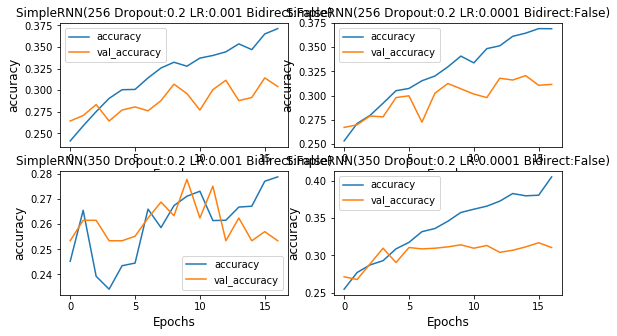

In [0]:
model_results_RNN_df = evaluate_categorical_models(rnn_layer_type=layers.SimpleRNN, bidirectional=False)

Model with hidden size 256, lr 0.001 and dropout 0.2 has test accuracy of 0.3542986512184143
Model with hidden size 256, lr 0.0001 and dropout 0.2 has test accuracy of 0.3067873418331146
Model with hidden size 350, lr 0.001 and dropout 0.2 has test accuracy of 0.3588235378265381
Model with hidden size 350, lr 0.0001 and dropout 0.2 has test accuracy of 0.3054298758506775


,Model,Test accuracy
0,LSTM(256 Dropout:0.2 LR:0.001 Bidirect:False),0.354299
1,LSTM(256 Dropout:0.2 LR:0.0001 Bidirect:False),0.306787
2,LSTM(350 Dropout:0.2 LR:0.001 Bidirect:False),0.358824
3,LSTM(350 Dropout:0.2 LR:0.0001 Bidirect:False),0.305430


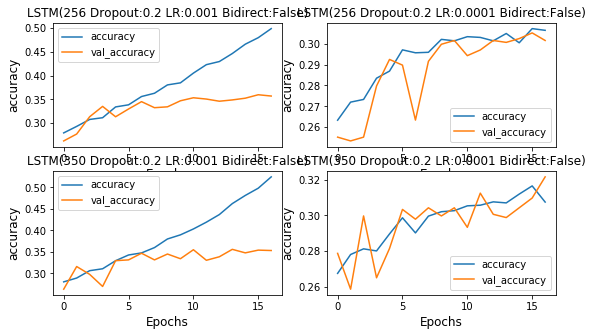

In [0]:
model_results_LSTM_df = evaluate_categorical_models(rnn_layer_type=layers.LSTM, bidirectional=False)

Model with hidden size 256, lr 0.001 and dropout 0.2 has test accuracy of 0.38235294818878174
Model with hidden size 256, lr 0.0001 and dropout 0.2 has test accuracy of 0.3049773871898651
Model with hidden size 350, lr 0.001 and dropout 0.2 has test accuracy of 0.3687782883644104
Model with hidden size 350, lr 0.0001 and dropout 0.2 has test accuracy of 0.3131221830844879


,Model,Test accuracy
0,GRU(256 Dropout:0.2 LR:0.001 Bidirect:False),0.382353
1,GRU(256 Dropout:0.2 LR:0.0001 Bidirect:False),0.304977
2,GRU(350 Dropout:0.2 LR:0.001 Bidirect:False),0.368778
3,GRU(350 Dropout:0.2 LR:0.0001 Bidirect:False),0.313122


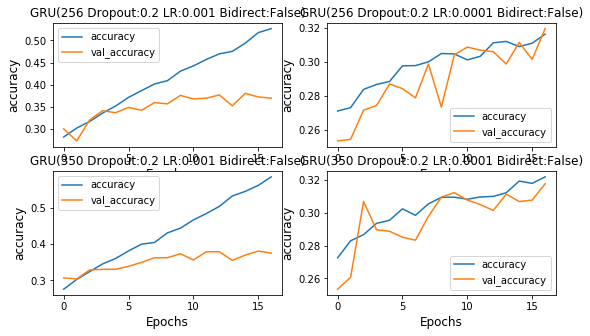

In [0]:
model_results_GRU_df = evaluate_categorical_models(rnn_layer_type=layers.GRU, bidirectional=False)


Model with hidden size 256, lr 0.001 and dropout 0.2 has test accuracy of 0.35520362854003906
Model with hidden size 256, lr 0.0001 and dropout 0.2 has test accuracy of 0.32488688826560974


,Model,Test accuracy
0,GRU(256 Dropout:0.2 LR:0.001 Bidirect:True),0.355204
1,GRU(256 Dropout:0.2 LR:0.0001 Bidirect:True),0.324887


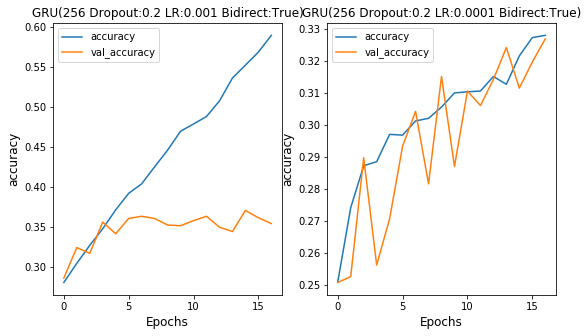

In [0]:
model_results_GRU_bi_df = evaluate_categorical_models(rnn_layer_type=layers.GRU, bidirectional=True)

### Task 4. Evaluate the models: Evaluate your best vanilla RNN, LSTM and GRU
models on the test data and compare the results of the three models. Use
precision, recall, and F1-measure to report the performance on the test
set. Compare the results of diffrent types of RNN architectures: vanilla
RNN, LSTM, GRU. Offer your intuition behind any observed difference
in performance between the models. For the best overall model, discuss
where your model is making mistakes. Use a confusion matrix plot to
support your answer.

> Validation performance did corelate with the test perfprmance, as can be seen in previous cells (tested at one run for all models. Afterwards I saw, it should be done only for a few and training took really long). 

> The performance between LSTM and GRU did not vary much, but RNN did perform poorly. The RNN did not even learn to predict some classes. 
> Confusion shows, that slighly more labels are misiterpreted, which has similar sentiment, that supports an idea, the model did understand partialy the sentiment. 



In [0]:
# Confusion matrix modified from: 
# https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/blob/master/SentimentAnalysisProject/emo_utils.py
def plot_confusion_matrix(y_actu, y_pred):
    cmap=plt.cm.gray_r
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) 

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))

    labels = list(sentiment_dict.values())
    labels.append("All")

    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)


    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [0]:
from sklearn.metrics import classification_report


def evaluate_best_model(model):
       
    model.fit( x=x_train_oh, y=y_train_oh, batch_size=64, epochs=17, verbose=False)
   
    y_predict = model.predict(x_test_oh, verbose=0)
    y_predict = y_predict.argmax(axis=1)
    plot_confusion_matrix(y_test_oh.argmax(axis=1), y_predict)

    target_names = sentiment_dict.values()
    print(classification_report(y_test_oh.argmax(axis=1), y_predict, target_names=target_names))


SimpleRNN(256 Dropout:0.2 LR:0.0001 Bidirect:F...	**0.304977**

                   precision    recall  f1-score   support

strongly negative       0.00      0.00      0.00       279
  weakly negative       0.36      0.21      0.27       633
          neutral       0.23      0.01      0.01       389
  weakly positive       0.25      0.88      0.39       510
strongly positive       0.54      0.02      0.03       399

         accuracy                           0.27      2210
        macro avg       0.28      0.22      0.14      2210
     weighted avg       0.30      0.27      0.18      2210



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


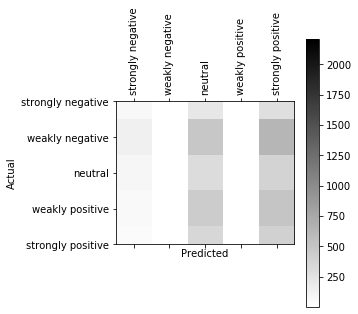

In [0]:
model = get_compiled_classification_model(rnn_layer_type=layers.SimpleRNN, lr=0.0001, hidden_size=256, dataset_example=x_train_oh, dropout=0.2, bidirectional=False, special_metrics=False)
evaluate_best_model(model)
    

Best model for LSTM:
> LSTM(350 Dropout:0.2 LR:0.001 Bidirect:False) -- **0.358824**

                   precision    recall  f1-score   support

strongly negative       0.41      0.12      0.19       279
  weakly negative       0.41      0.46      0.43       633
          neutral       0.27      0.25      0.26       389
  weakly positive       0.29      0.35      0.31       510
strongly positive       0.38      0.43      0.41       399

         accuracy                           0.35      2210
        macro avg       0.35      0.32      0.32      2210
     weighted avg       0.35      0.35      0.34      2210



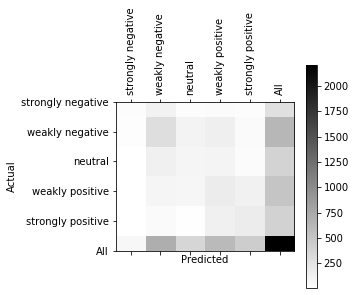

In [0]:
model = get_compiled_classification_model(rnn_layer_type=layers.LSTM, lr=0.001, hidden_size=350, dataset_example=x_train_oh, dropout=0.2, bidirectional=False, special_metrics=False)
evaluate_best_model(model)

Best model for GRU:
> GRU(256 Dropout:0.2 LR:0.001 Bidirect:False)	**0.382353**


                   precision    recall  f1-score   support

strongly negative       0.31      0.11      0.16       279
  weakly negative       0.43      0.32      0.37       633
          neutral       0.23      0.42      0.30       389
  weakly positive       0.33      0.38      0.35       510
strongly positive       0.45      0.37      0.41       399

         accuracy                           0.34      2210
        macro avg       0.35      0.32      0.32      2210
     weighted avg       0.36      0.34      0.33      2210



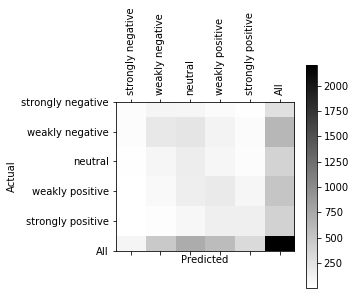

In [0]:
model = get_compiled_classification_model(rnn_layer_type=layers.GRU, lr=0.001, hidden_size=256, dataset_example=x_train_oh, dropout=0.2, bidirectional=False, special_metrics=False)
evaluate_best_model(model)
    


## Text Generating Model

In [0]:
# Code is mainly modified Tensorflow tutorial on a text generation task at
# https://www.tensorflow.org/tutorials/text/text_generation

#### Prepare dataset and characters vocabuary


In [0]:
# Create a dictanionary of characters
whole_corpus = train_ds["sentence"] 
whole_corpus.append(test_ds["sentence"])
whole_corpus.append(dev_ds["sentence"])

# Convert data to ascii
whole_corpus = whole_corpus.apply(lambda x: x.encode("ascii", "ignore").decode("ascii"))

# The unique characters in the file
text = ' '.join(whole_corpus)
vocab = sorted(set(text))
print(text[:300])

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not


#### Create mapping to indicies

In [0]:
import numpy as np 
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])


#### Create training batches

In [0]:

# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)


# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


#### Create the model 

In [0]:
vocab_size = len(vocab)


def build_model(vocab_size=vocab_size, embedding_dim=256, rnn_units=1024, batch_size=BATCH_SIZE):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
    ])
    return model



def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model = build_model()
model.compile(optimizer='adam', loss=loss)

#### Train the model 

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = PROJECT_PATH + '/training_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)



###### Customized Training


In [0]:

EPOCHS=1000

model = build_model(batch_size=BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


for epoch in range(400, EPOCHS):

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if (batch_n +1) % 128 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 100 epochs
  if (epoch + 1) % 100 == 0:
    print(f"Saving Epoch: {epoch + 1}")
    model.save_weights(checkpoint_prefix.format(epoch=epoch))


model.save_weights(checkpoint_prefix.format(epoch=epoch))

##### Closed Training

In [0]:
# history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

#### Evaluate model at epochs
* Show samples of the text generated by your model at an early stage of the
training (e.g., after 100 epochs), at an intermediate stage (e.g., after 500 epochs)
and at a later stage (e.g., after 1000 epochs). Give a qualitative discussion of
the results. Where does the model do well? Where does it seem to fail?

> I did train only 500 epochs, because it took so long to train and results did not really seem to imporve much. 
> The model does not seem to understand the word followup, but it is quite good, at actually generating the word, which does express something common with movie reviews. 
> Here I show the outut of the model at some epochs on the input sentences starting with: ___It is a___ and ___The___




==Model at epoch 99==


It is a character study with American action and Barbershop .

The Rice 's now we 've got seem like some of the characters ' lives and conventions and sings and point


==Model at epoch 199==


It is a movie that is a film that is so story .

The Paid '' and `` the movie 's contrived , and the film 's camera between the movie 's part of the mov


==Model at epoch 299==


It is a completely contrived as the movie is a conventional , but it 's a pretty movie .

The Opera 's down the story 's most of the movie 's story of the most consume to a couple 's an extreme


==Model at epoch 399==


It is a some that it 's a star , and the film 's and the film a film the film 's and the film a comedy and t

Theme has film a film 's a film a film and the film 's a film a film and the film 's a film the complex


==Model at epoch 499==


It is a goofy makes it a surprisingly surprisingly surprisingly surprising of the story .

The little of the movie is a bit of a man who is a tribute to the performances are so strange and subtl

In [0]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 100

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.1

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        if idx2char[predicted_id] == ".":
            break

    return (start_string + ''.join(text_generated))


def generate_at_epoch(epoch=100):
    model = build_model(batch_size=1)

    epoch_checkpoint = checkpoint_dir + f"/ckpt_{epoch}"
    # print(epoch_checkpoint)
    model.load_weights(epoch_checkpoint)

    model.build(tf.TensorShape([1, None]))

    text = generate_text(model, "It is a ")
    text += "\n\n"
    text += generate_text(model, "The")
    return text


for epoch in [99, 199, 299, 399, 499]:
    print(f"\n\n==Model at epoch {epoch}==\n\n")
    print(generate_at_epoch(epoch=epoch))



==Model at epoch 99==


It is a character study with American action and Barbershop .

The Rice 's now we 've got seem like some of the characters ' lives and conventions and sings and point


==Model at epoch 199==


It is a movie that is a film that is so story .

The Paid '' and `` the movie 's contrived , and the film 's camera between the movie 's part of the mov


==Model at epoch 299==


It is a completely contrived as the movie is a conventional , but it 's a pretty movie .

The Opera 's down the story 's most of the movie 's story of the most consume to a couple 's an extreme


==Model at epoch 399==


It is a some that it 's a star , and the film 's and the film a film the film 's and the film a comedy and t

Theme has film a film 's a film a film and the film 's a film a film and the film 's a film the complex


==Model at epoch 499==


It is a goofy makes it a surprisingly surprisingly surprisingly surprising of the story .

The little of the movie is a bit of a man who i